In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib

# set path to FMD image directory
data_dir = pathlib.Path("image")

# total no. of images in FMD dataset
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1000


In [5]:
# set batch size for training
batch_size = 16

# set dimensions to change images into for training
# 299x299 images is used to train for consistency between different pre-trained models
img_height = 299
img_width = 299

In [6]:
# create dataset from the image directory
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'), shuffle=False)
# shuffle the 1,000 images with the random seed value of 123 before training
list_ds = list_ds.shuffle(image_count, seed=123, reshuffle_each_iteration=False)

In [8]:
# get class names from the folder names in data_dir
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['fabric' 'foliage' 'glass' 'leather' 'metal' 'paper' 'plastic' 'stone'
 'water' 'wood']


In [9]:
# split dataset into 5 equal sized parts for 5-fold cross validation
A = list_ds.shard(num_shards=5, index=0)
B = list_ds.shard(num_shards=5, index=1)
C = list_ds.shard(num_shards=5, index=2)
D = list_ds.shard(num_shards=5, index=3)
E = list_ds.shard(num_shards=5, index=4)

In [15]:
# check no. of samples in each partition is the same
print(A.cardinality().numpy())
print(B.cardinality().numpy())
print(C.cardinality().numpy())
print(D.cardinality().numpy())
print(E.cardinality().numpy())

200
200
200
200
200


In [16]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [17]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [18]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [19]:
# prompt the tf.data runtime to tune the number of elements to prefetch dynamically at runtime
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [20]:
# use the path of image to load the image into each partition of the dataset
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
A = A.map(process_path, num_parallel_calls=AUTOTUNE)
B = B.map(process_path, num_parallel_calls=AUTOTUNE)
C = C.map(process_path, num_parallel_calls=AUTOTUNE)
D = D.map(process_path, num_parallel_calls=AUTOTUNE)
E = E.map(process_path, num_parallel_calls=AUTOTUNE)

In [21]:
for image, label in A.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (299, 299, 3)
Label:  1


In [22]:
# shuffle, batch, and prefetch the dataset
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [23]:
# map the dataset partitions to integers for building training/test sets during cross-validation
ds_fold_dict = {0:A, 1:B, 2:C, 3:D, 4:E}

In [24]:
# normalise the input values to the pre-trained model's required range of values
preprocess_input = keras.applications.resnet_v2.preprocess_input

In [25]:
# set a low learning rate to avoid overfitting too quickly
base_learning_rate = 0.0001

# create the model to train using the pre-trained model as base model
def create_model(base_model):
  # generate additional training data from input training data by augmenting them using random flip, rotation & zoom
  data_augmentation = keras.Sequential(
    [
      layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                  input_shape=(img_height, 
                                                                img_width,
                                                                3)),
      layers.experimental.preprocessing.RandomRotation(0.1),
      layers.experimental.preprocessing.RandomZoom(0.1),
    ]
  )

  # average over the spatial locations to convert the features to a single vector per image
  global_average_layer = keras.layers.GlobalAveragePooling2D()
  # convert these features into a single prediction per image
  prediction_layer = keras.layers.Dense(10)

  # Build a model by chaining together the layers using the Keras Functional API.
  inputs = keras.Input(shape=(img_height, img_width, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False) # use training=False as the base model contains a BatchNormalization layer
  x = global_average_layer(x)
  x = keras.layers.Dropout(0.2)(x) # add dropout to fully connected layer to reduce overfitting
  outputs = prediction_layer(x)
  model = keras.Model(inputs, outputs)
  optimizer = keras.optimizers.Adam(lr=base_learning_rate)
  loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  # compile model with Adam optimizer with specified learning rate
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
  model.summary()
  return model

In [26]:
no_epochs = 50
fine_tune_epochs = 20
total_epochs =  no_epochs + fine_tune_epochs
# Fine-tune from this layer onwards
fine_tune_at = -27

In [27]:
# store results to plot graphs and get cross-validated accuracies
history_map = {}
base_model_acc_list = []
pre_trained_acc_list = []
final_acc_list = []

# do 5-fold cross-validation
for i in range(5):
  print('fold', i + 1)
  temp_dict = ds_fold_dict.copy()
  # get test set for this iteration
  current_val_ds = temp_dict[i]

  # get training set for this iteration from remaining data samples
  del temp_dict[i]
  current_train_ds = None
  for ds_shard in temp_dict.values():
    if current_train_ds is None:
      current_train_ds = ds_shard
    else:
      current_train_ds = current_train_ds.concatenate(ds_shard)
  
  # configure both training and test sets to improve performance
  current_train_ds = configure_for_performance(current_train_ds)
  current_val_ds = configure_for_performance(current_val_ds)

  # get pre-trained model
  base_model = keras.applications.ResNet152V2(include_top=False, input_shape=(img_height, img_width, 3))
  # don't train base model weights
  base_model.trainable = False

  # create a new model
  model = create_model(base_model)
  # get initial test accuracy
  base_model_acc_list.append(model.evaluate(current_val_ds)[1])
  # train for specified epochs
  history = model.fit(current_train_ds,
                    epochs=no_epochs,
                    validation_data=current_val_ds)
  
  # get test accuracy before fine-tuning
  pre_trained_acc_list.append(model.evaluate(current_val_ds)[1])

  # start fine-tuning by setting base model to be trainable
  base_model.trainable = True

  # Freeze all the layers before the `fine_tune_at` layer to only fine-tune top layer(s)
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

  # compile model again with RMSProp optimizer with even smaller learning rate to reduce overfitting
  optimizer = keras.optimizers.RMSprop(lr=base_learning_rate/10)
  loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
  print('Fine-tuned model:')
  model.summary()

  # train fine-tuned model
  history_fine = model.fit(current_train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=current_val_ds)

  # save results
  if i == 0:
    history_map['accuracy'] = [history.history['accuracy'] + history_fine.history['accuracy']]
    history_map['val_accuracy'] = [history.history['val_accuracy'] + history_fine.history['val_accuracy']]
    history_map['loss'] = [history.history['loss'] + history_fine.history['loss']]
    history_map['val_loss'] = [history.history['val_loss'] + history_fine.history['val_loss']]
  else:
    history_map['accuracy'].append(history.history['accuracy'] + history_fine.history['accuracy'])
    history_map['val_accuracy'].append(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
    history_map['loss'].append(history.history['loss'] + history_fine.history['loss'])
    history_map['val_loss'].append(history.history['val_loss'] + history_fine.history['val_loss'])
  
  # get final test accuracy by taking the max accuracy over the whole training due to potential overfitting at end of fine-tuning
  final_acc_list.append(np.amax(history.history['val_accuracy'] + history_fine.history['val_accuracy']))

===================] - 7s 150ms/step - loss: 0.3979 - accuracy: 0.8825 - val_loss: 0.5794 - val_accuracy: 0.8300
Epoch 36/50
50/50 [==============================] - 8s 150ms/step - loss: 0.4012 - accuracy: 0.8900 - val_loss: 0.5745 - val_accuracy: 0.8400
Epoch 37/50
50/50 [==============================] - 8s 151ms/step - loss: 0.3604 - accuracy: 0.9100 - val_loss: 0.5715 - val_accuracy: 0.8350
Epoch 38/50
50/50 [==============================] - 8s 150ms/step - loss: 0.3829 - accuracy: 0.9038 - val_loss: 0.5621 - val_accuracy: 0.8500
Epoch 39/50
50/50 [==============================] - 8s 151ms/step - loss: 0.3638 - accuracy: 0.9087 - val_loss: 0.5620 - val_accuracy: 0.8400
Epoch 40/50
50/50 [==============================] - 8s 150ms/step - loss: 0.3481 - accuracy: 0.9150 - val_loss: 0.5559 - val_accuracy: 0.8400
Epoch 41/50
50/50 [==============================] - 8s 151ms/step - loss: 0.3584 - accuracy: 0.9050 - val_loss: 0.5563 - val_accuracy: 0.8350
Epoch 42/50
50/50 [==========

In [28]:
# cross-validated accuracy for pre-trained model before training
print("Base model accuracy:", np.mean(base_model_acc_list))
# cross-validated accuracy before fine-tuning
print("Accuracy before fine-tuning:", np.mean(pre_trained_acc_list))
# cross-validated accuracy after fine-tuning
print("Final accuracy:", np.mean(final_acc_list))

Base model accuracy: 0.12899999767541886
Accuracy before fine-tuning: 0.8179999947547912
Final accuracy: 0.8540000081062317


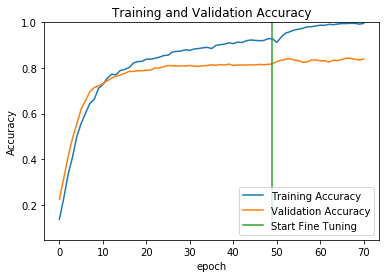

In [29]:
# plot graph of cross-validated accuracies
acc = np.mean(history_map['accuracy'], axis=0)
val_acc = np.mean(history_map['val_accuracy'], axis=0)

plt.figure(1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([no_epochs-1,no_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.show()

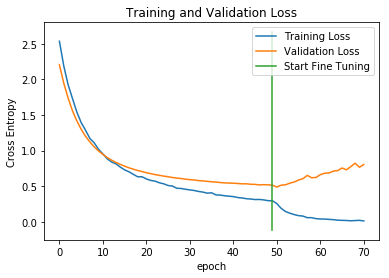

In [30]:
# plot graph of cross-validated losses
loss = np.mean(history_map['loss'], axis=0)
val_loss = np.mean(history_map['val_loss'], axis=0)

plt.figure(2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([no_epochs-1,no_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()